<a href="https://colab.research.google.com/github/sanaamouzahir/NonLinearModelling/blob/main/MCMC2ndattempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math as m
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from google.colab import files

uploaded = files.upload()

Saving inferencedata.mat to inferencedata.mat
Saving ktrue.mat to ktrue.mat


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving covariance_matrix.mat to covariance_matrix.mat
Saving inferencedata.mat to inferencedata.mat
Saving ktrue.mat to ktrue.mat


In [4]:
import scipy.io

# Load MATLAB data file
inference_data= scipy.io.loadmat('inferencedata.mat')
ktrue=scipy.io.loadmat('ktrue.mat')
xobserved=inference_data['xobserved']
Uobserved=inference_data['Uobserved'].reshape(10)
k_true=ktrue['ktrue']
xgrid=ktrue['xgrid']


In [ ]:
cov=scipy.io.loadmat('covariance_matrix.mat')
cov=cov['Cov matrix:']

In [5]:
# Copyright 2023 Daniel Sharp
# Permission is hereby granted, free of charge, to any person
# obtaining a copy of this software and associated documentation
# files (the “Software”), to deal in the Software without
# restriction, including without limitation the rights to use,
# copy, modify, merge, publish, distribute, sublicense, and/or
# sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following
# conditions:
# The above copyright notice and this permission notice shall be
# included in all copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
# EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
# OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
# HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
# WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
# OTHER DEALINGS IN THE SOFTWARE.

import numpy as np

def covfun(x1, x2, L=0.3, var_y=0.3):
    return var_y*np.exp(-np.abs(x1-x2)/L)

def form_KL_uniform(covfun, lo, hi, num_quad):
    pts, wts = np.polynomial.legendre.leggauss(num_quad)
    pts = (pts * (hi-lo)/2) + (hi + lo)/2
    wts *= (hi-lo)/2
    mesh1, mesh2 = np.meshgrid(pts, pts)
    C_mat = covfun(mesh1, mesh2)
    W_half = np.diag(np.sqrt(wts))
    A = W_half @ C_mat @ W_half
    lam, phi = np.linalg.eigh(A)
    psi = np.diag(1 / np.sqrt(wts)) @ phi
    lam = lam[::-1]
    psi = psi[:,::-1]
    psi = psi * (2*(psi[0,:] > 0) - 1)
    return lam, psi, pts, wts

class KLE:
    def __init__(self, lam, psi, pts, wts, covfun):
        self.lam = lam
        self.psi = psi
        self.pts = pts
        self.wts = wts
        self.covfun = covfun

def default_KLE(N_trunc, num_quad = 100):
    lam, psi, pts, wts = form_KL_uniform(covfun, 0., 1., num_quad)
    return KLE(lam[:N_trunc], psi[:,:N_trunc], pts, wts, covfun)

def eval_KLE(kl, xgrid, z = None):
    if z is None:
        rng = np.random.default_rng()
        z = rng.standard_normal(len(kl.lam))
    X,Y = np.meshgrid(kl.pts, xgrid)
    covmat = kl.covfun(X,Y) @ np.diag(kl.wts)
    psi_evals = covmat @ kl.psi @ np.diag(1/np.sqrt(kl.lam))
    return psi_evals,kl.lam

def ExampleKLE():
    # Load data
    data = scipy.io.loadmat('inferencedata.mat')
    x_observed = data['xobserved'].flatten()
    U_observed = data['Uobserved'].flatten()
    xgrid = x_observed
    n_trunc = 100
    kl = default_KLE(n_trunc, max(100, round(1.5*n_trunc)))
    rng = np.random.default_rng()
    z = rng.standard_normal(n_trunc)
    kl_eval = eval_KLE(kl, xgrid, z)
    return xgrid, kl_eval, z



In [6]:

def diffusioneqn(xgrid, F, k, source, rightbc):
    N = len(xgrid)
    h = xgrid[N-1] - xgrid[N-2]

    A = np.zeros((N-1, N-1))
    b = np.zeros(N-1)

    if isinstance(source, (int, float)):
        f = -source * np.ones(N-1)
    else:
        f = -source[:N-1]

    A -= np.diag(2*k[:-1] + k[1:] + np.insert(k[:-2],0,k[0]))
    A += np.diag(  k[:-2] + k[1:-1], 1)
    A += np.diag(  k[:-2] + k[1:-1],-1)
    A /= 2 * h**2


    A[0, 1] += k[0] / h**2
    b[0] = 2 * F / h

    b[N-2] = rightbc * (k[N-1] + k[N-2]) / (2 * h**2)

    uinternal = np.linalg.solve(A, f - b)
    usolution = np.append(uinternal, rightbc)

    usolution=np.array([usolution[0],usolution[10],usolution[20],usolution[30],usolution[40],usolution[50],usolution[60],usolution[70],usolution[80],usolution[90]])

    return usolution

In [7]:
import numpy as np

from scipy.stats import multivariate_normal



def calc_Gauss_mv(x, mean, cov):
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    exponent_term = -0.5 * np.dot((x - mean).T, np.dot(inv_cov, (x - mean)))
    output_val = exponent_term
    return output_val



import numpy as np

def mvnrnd(mu, sigma):
    R = np.linalg.cholesky(sigma)
    sample = mu + np.dot(R, np.random.randn(len(mu)))
    return sample



In [191]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

x =np.arange(0, 1.01, 0.01)

# Get truncated KL modes
mu_y = 1
KL_trunc_order = 10


KL=default_KLE(KL_trunc_order, num_quad = 100)

psi, lambda_ = eval_KLE(KL,x, z = None)



# Create mean and covariance matrices for prior and likelihood
sigma_e_2 = 1e-4
cov_data_obs = np.diag(sigma_e_2 * np.ones(10)) # Given in the project, variance of the noise
cov_Z_prior = np.diag(np.ones(KL_trunc_order)) # Identity matrix is the prior since prior we work with the asusmption that the Zs are iid standard normal
mean_Z_prior = np.zeros(KL_trunc_order)

# Parameters for the PDE solver
u_r = 1
F = -1
m_wall = np.array([0.2, 0.4, 0.6, 0.8])
s_width = 0.05
s_strength = 0.8

s = np.zeros_like(x) # How the source term was defined
for i in range(len(x)):
    s[i] = (s_strength / (np.sqrt(2 * np.pi) * s_width)) * np.sum(
        np.exp(-0.5 * ((x[i] - m_wall) ** 2) / s_width ** 2)
    )

N=10000

# MCMC Random walk parameter try for one parameter
np.random.seed(5)
cov_MCMC = np.eye(10)


MC_x = np.zeros((KL_trunc_order, N))

Y_1 = mu_y + (MC_x[:, 0]).dot(psi.T) # Gaussian prior
k_1 = np.exp(Y_1)

obs_mean_1 = diffusioneqn(x, F, k_1,s,u_r)
obs_mean_prev=obs_mean_1

# Start MCMC chains
accept=0
for chain_time in range(1, N):  # Start from 1 since chain_time - 1 is used

    # Adaptive MC
    sd = 2.4 ** 2 / KL_trunc_order
    adaptive_eps = 0.01

    if chain_time > 1000: # Covariance matrix of the random coefficients
        cov_MCMC = (
            sd * np.cov(MC_x[:, chain_time-1].T)
            + sd * adaptive_eps * np.eye(KL_trunc_order)
        )


    # Proposal (y/x_n)
    #Mc_x: vector mean of joint distribution of Zis
    # covMCMC: Covariance of Zis
    # calc_gauss: returns multivariatenormalpdf

    proposal = mvnrnd(MC_x[:, chain_time - 1], cov_MCMC)

    Y_proposal = mu_y + ( proposal).dot(psi.T)
    k_proposal = np.exp(Y_proposal)

    obs_mean_proposal = diffusioneqn(x, F, k_proposal, s, u_r)

    # Evaluate all PDFs for alpha term
    pi_y =calc_Gauss_mv(Uobserved, obs_mean_proposal, cov_data_obs)+calc_Gauss_mv(proposal, mean_Z_prior, cov_Z_prior)


    pi_xn = calc_Gauss_mv(Uobserved, obs_mean_prev, cov_data_obs)+calc_Gauss_mv(MC_x[:, chain_time - 1], mean_Z_prior, cov_Z_prior)


    q_xn_y = calc_Gauss_mv(MC_x[:, chain_time - 1], proposal, cov_MCMC)
    q_y_xn = calc_Gauss_mv(proposal, MC_x[:, chain_time - 1], cov_MCMC)


    alpha =min(1,np.exp(pi_y + q_xn_y - pi_xn- q_y_xn))

    # Update next sample
    if np.random.rand() < alpha:
        MC_x[:, chain_time] = proposal
        Y_prev = Y_proposal
        obs_mean_prev = obs_mean_proposal
        accept+=1
    else:
        MC_x[:, chain_time] = MC_x[:, chain_time - 1]








In [185]:
!pip install emcee
import emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 952.0 kB/s eta 0:00:00


In [192]:
print('Accepance rate ratio',accept/N)

Accepance rate ratio 0.0632


In [196]:
t_burn_in = 2000
Y_MCMC = np.zeros((len(x), N-t_burn_in))
k_MCMC = np.zeros((len(x), N-t_burn_in))
u_MCMC=np.zeros(N-t_burn_in)
for j in range(t_burn_in , N):
  i = j - t_burn_in
  Y_MCMC[:, i ] = mu_y + (MC_x[:, j ]).dot(psi.T)
  k_MCMC[:, i ] = np.exp(Y_MCMC[:, i ])
  u_MCMC[i]=diffusioneqn(x, F, k_MCMC[:, i ], s, u_r)[0]

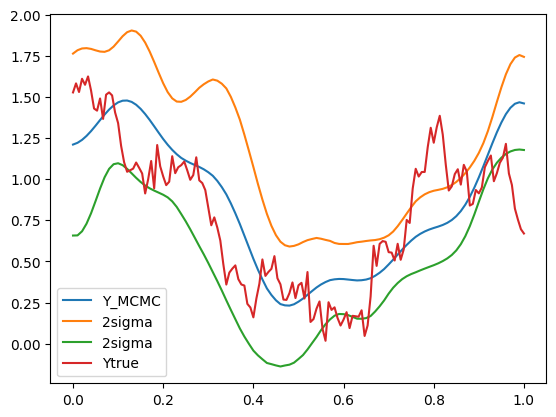

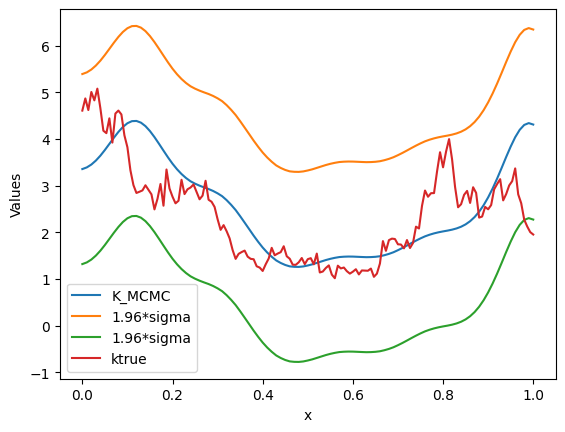

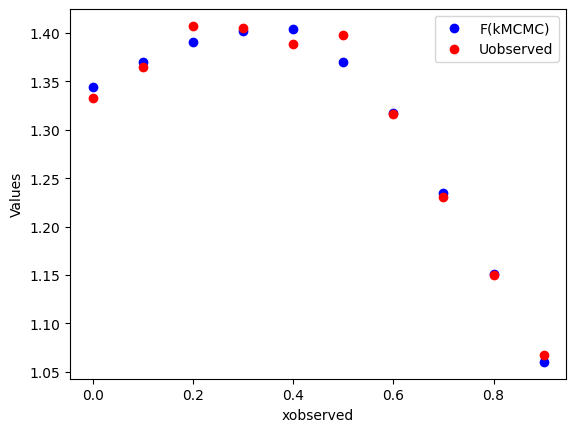

In [ ]:

t_burn_in = 50000
Y_MCMC = np.zeros((len(x), N-t_burn_in))
k_MCMC = np.zeros((len(x), N-t_burn_in))
u_MCMC=np.zeros(N-t_burn_in)
for j in range(t_burn_in , N):
  i = j - t_burn_in
  Y_MCMC[:, i ] = mu_y + (MC_x[:, j ]).dot(psi.T)
  k_MCMC[:, i ] = np.exp(Y_MCMC[:, i ])
  u_MCMC[i]=diffusioneqn(x, F, k_MCMC[:, i ], s, u_r)[0]
import numpy as np
import matplotlib.pyplot as plt

# Assuming x, Y_MCMC, ktrue, xgrid, xobserved, u_r, F, s, mean, std, u_values, and Uobserved are defined

# Plotting the first set of curves
plt.figure()
plt.plot(x, Y_MCMC[:,len(Y_MCMC)-1], label='Y_MCMC')
plt.plot(x, Y_MCMC[:,len(Y_MCMC)-1] + 2*np.std(Y_MCMC, axis=1), label='2sigma')
plt.plot(x, Y_MCMC[:,len(Y_MCMC)-1] - 2*np.std(Y_MCMC, axis=1), label='2sigma')
plt.plot(xgrid, np.log(k_true), label='Ytrue')
plt.legend()

# Plotting the first set of curves
plt.figure()
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]),label='K_MCMC')
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]) + 1.96*np.std(np.exp(Y_MCMC[:,len(Y_MCMC)])), label='1.96*sigma')
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]) - 1.96*np.std(np.exp(Y_MCMC[:,len(Y_MCMC)])), label='1.96*sigma')
# Plotting ktrue
plt.plot(xgrid, k_true, label='ktrue')

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the second set of curves
plt.figure()
plt.plot(xobserved, diffusioneqn(x,F,k_MCMC[:,len(k_MCMC)],s,u_r),'bo', label='F(kMCMC)')
plt.plot(xobserved, Uobserved, 'ro', label='Uobserved')

# Adding labels and legend
plt.xlabel('xobserved')
plt.ylabel('Values')
plt.legend()
plt.show()


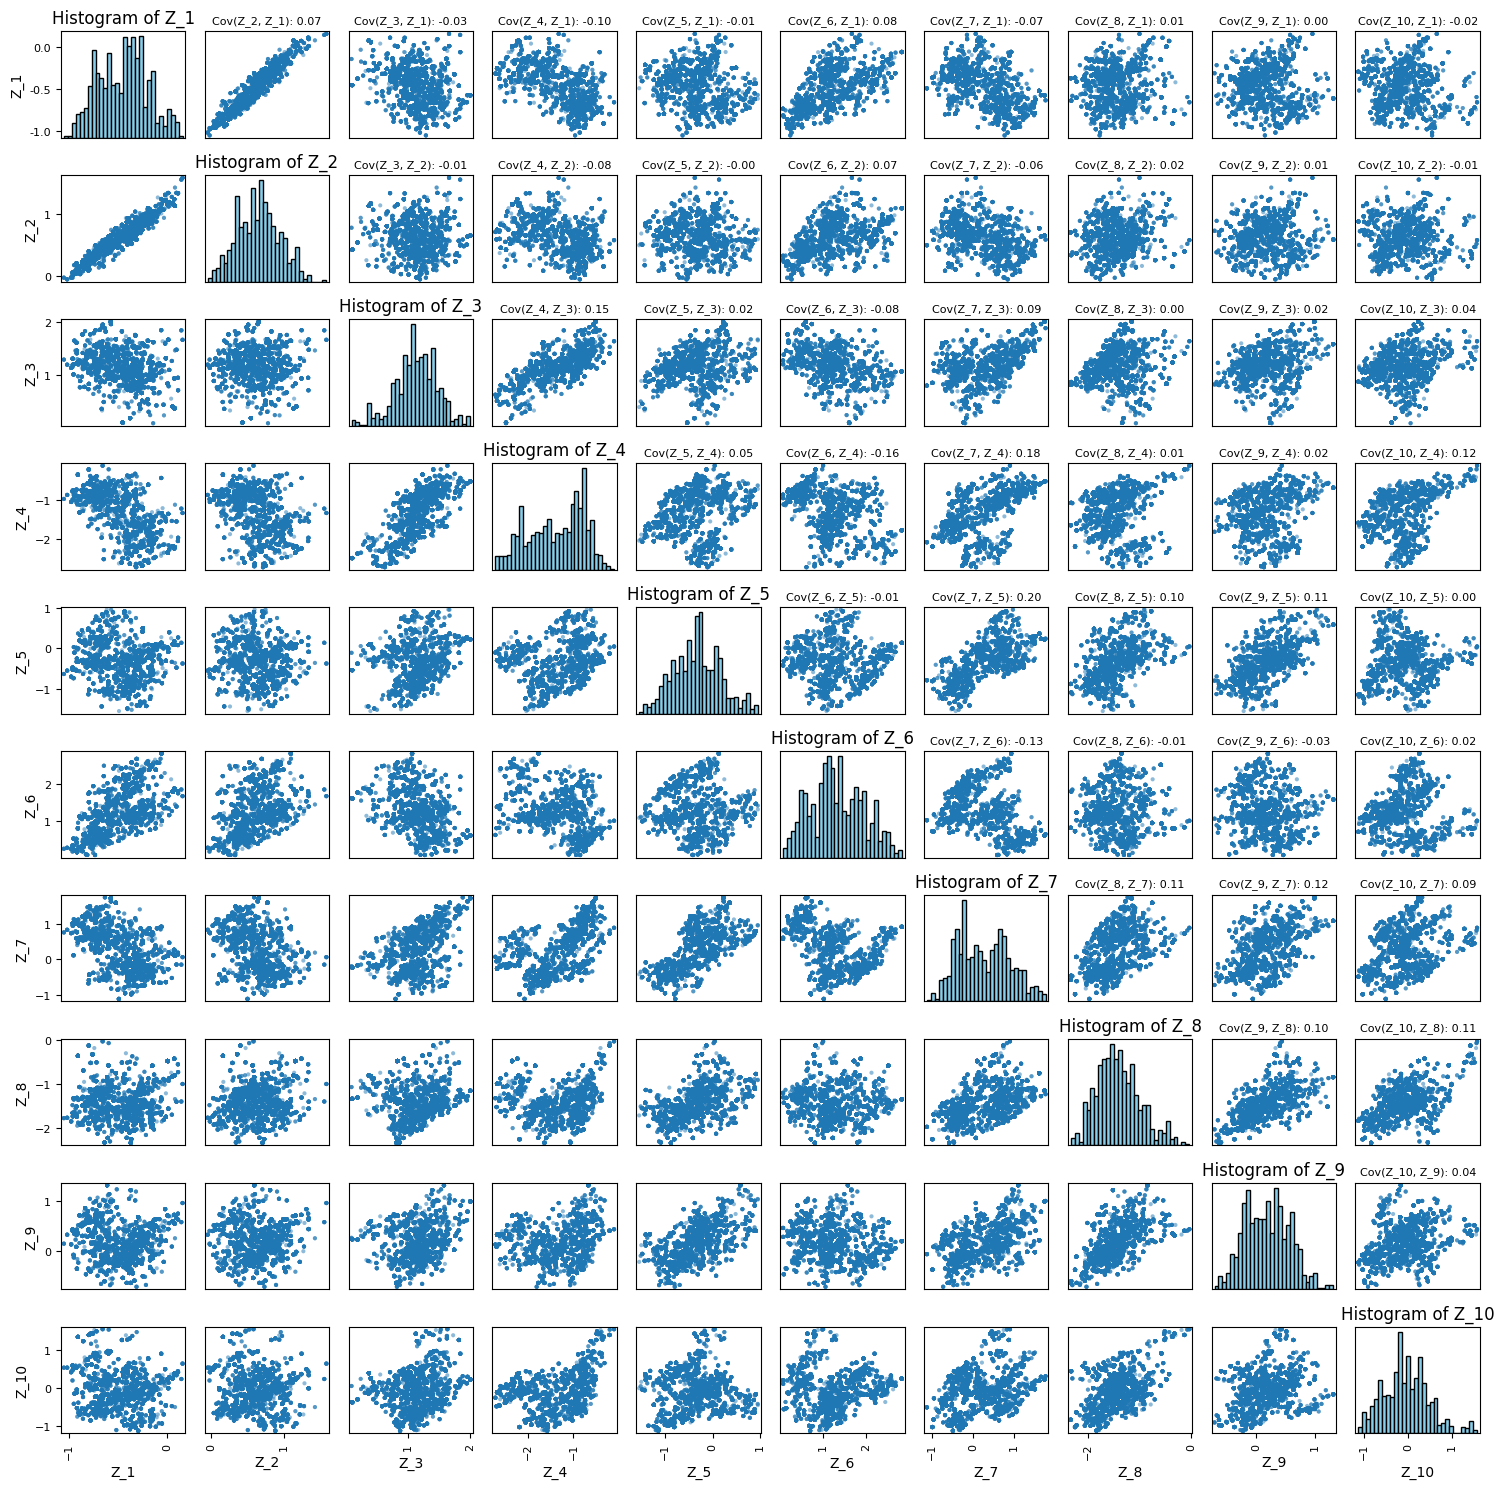

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data
t_burn_in = 2000  # Adjust based on your data

# Create a DataFrame from MC_x
df = pd.DataFrame(MC_x[:, t_burn_in:].T, columns=[f'Z_{i+1}' for i in range(KL_trunc_order)])

# Calculate covariance matrix for MC_x
covariance_matrix = np.cov(df, rowvar=False)

# Create a scatter matrix with histograms
scatter_matrix = pd.plotting.scatter_matrix(df, figsize=(15, 15), diagonal='hist', hist_kwds={'bins': 30, 'color': 'skyblue', 'edgecolor': 'black'})

# Add titles to the diagonal histograms
for i, ax in enumerate(scatter_matrix.diagonal()):
    ax.set_title(f'Histogram of {df.columns[i]}')

# Add covariance values to off-diagonal plots
for i in range(len(scatter_matrix) - 1):
    for j in range(i + 1, len(scatter_matrix)):
        scatter_matrix[i, j].set_title(f'Cov({df.columns[j]}, {df.columns[i]}): {covariance_matrix[i, j]:.2f}', fontsize=8)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [194]:
import numpy as np
import matplotlib.pyplot as plt



# Plotting the histogram
plt.hist(u_MCMC, bins=30, density=True, alpha=0.7, color='blue', label='u_MCMC')

# Calculate mean and variance
mean_value = np.mean(u_MCMC)
variance_value = np.var(u_MCMC)

# Plotting mean and variance lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mean_value + np.sqrt(variance_value), color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {np.sqrt(variance_value):.2f}')
plt.axvline(mean_value - np.sqrt(variance_value), color='green', linestyle='dashed', linewidth=2)

# Adding labels and title
plt.xlabel('u(x=0,w)')
plt.ylabel('Probability Density')
plt.title('Histogram of u(x=0,w)')
plt.legend()

plt.show()


NameError: ignored

In [ ]:
cov1 = np.cov(Y_MCMC)  # No truncation, no expansion
def covariance(X1,X2):
    Abs = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            Abs[i,j] = np.abs(X1[i]-X2[j])
    return 0.3*np.exp(-(Abs/0.3)**1/1)
cov2=covariance(x,x)





In [ ]:
cov=np.cov(MC_x[:, t_burn_in:])
from scipy.io import savemat

from google.colab import drive
drive.mount('/content/drive')
save_path='/content/drive/My Drive/covariance_matrix.mat'

savemat(save_path,{'Cov matrix:':cov})
import os
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


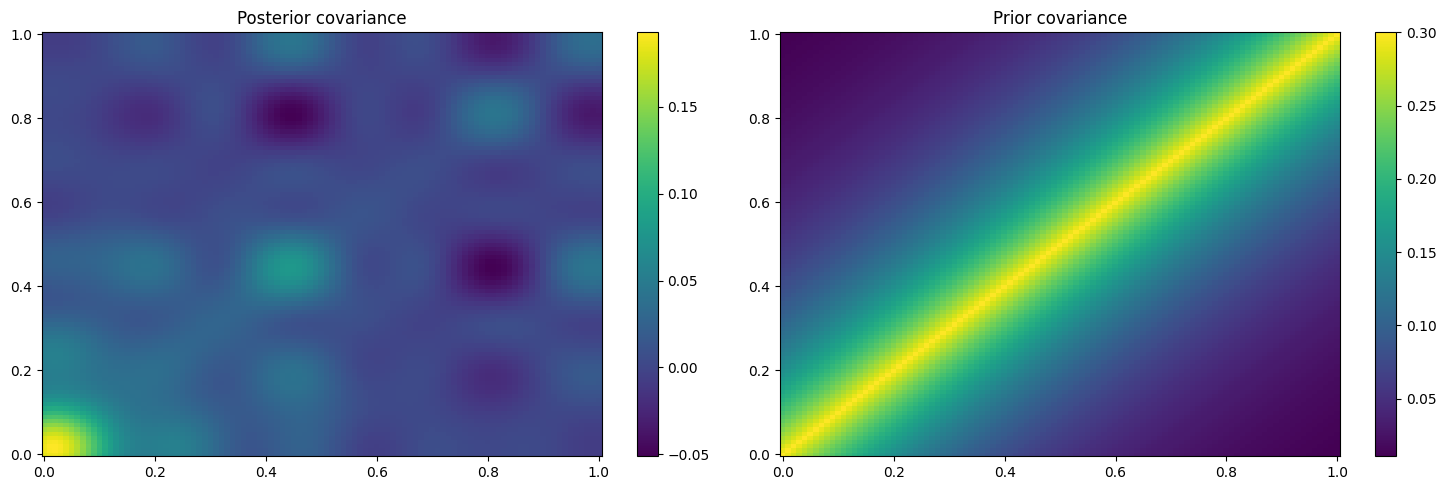

In [ ]:


# Create subplots for the three plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first covariance matrix
cax1 = axes[0].pcolor(x, x, cov1)
axes[0].set_title('Posterior covariance')
fig.colorbar(cax1, ax=axes[0])

# Plot the second covariance matrix
cax2 = axes[1].pcolor(x, x, cov2)
axes[1].set_title('Prior covariance')
fig.colorbar(cax2, ax=axes[1])

plt.tight_layout()
plt.show()


ValueError: ignored

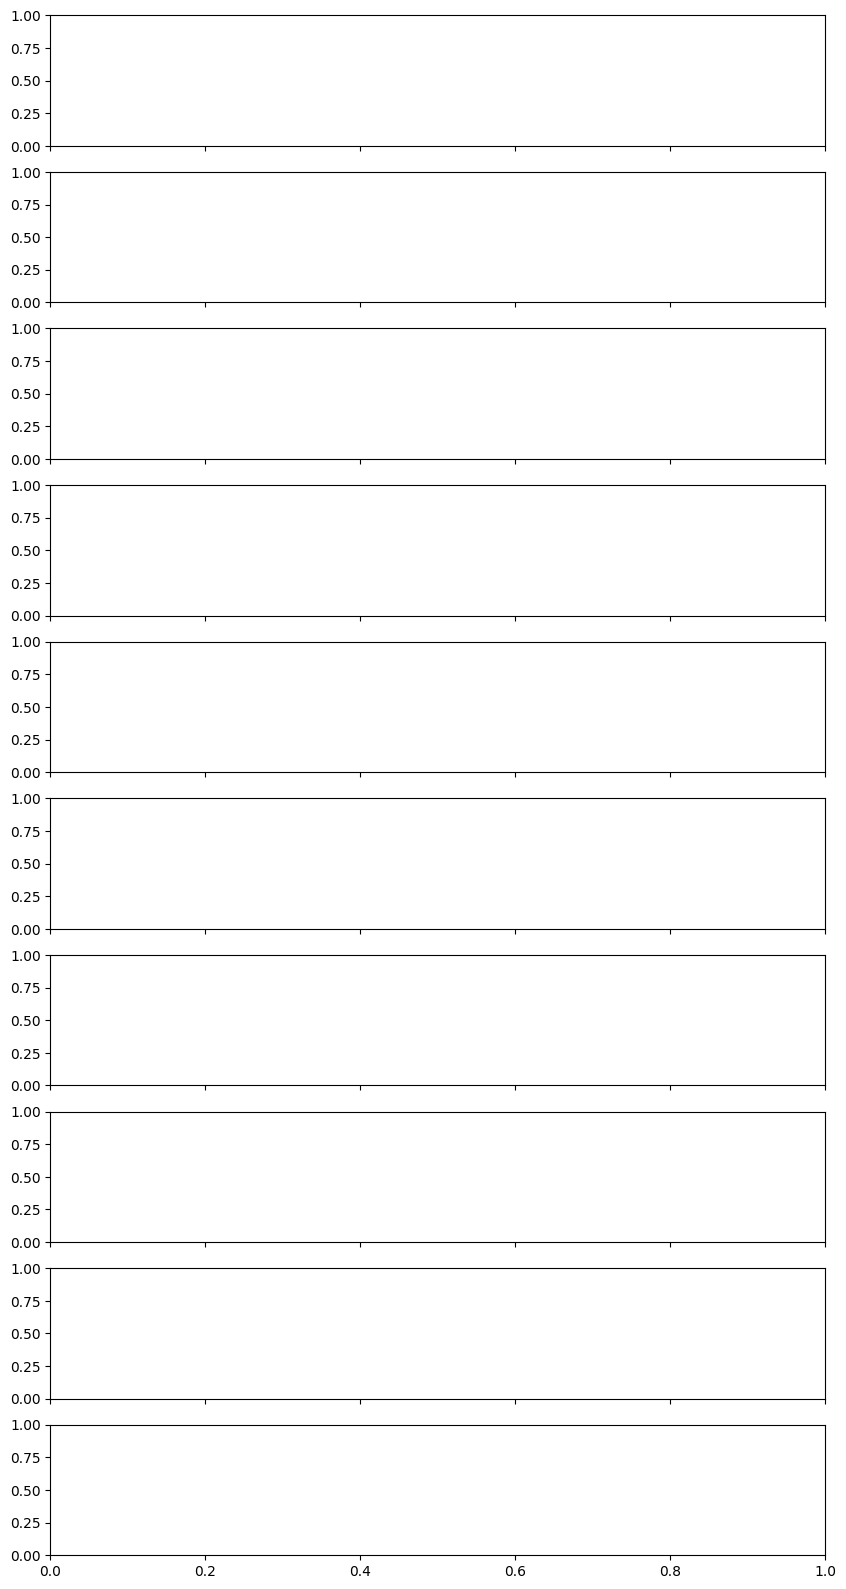

In [189]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data

# Plotting all Zi in a single plot with subplots
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 2 * KL_trunc_order), sharex=True)

for i in range(KL_trunc_order):
    axs[i].plot(range(1000,num_iterations), MC_x[i, 1000:], label=f'Z_{i+1}')
    axs[i].set_ylabel(f'Z_{i+1} Values')
    axs[i].legend()

# Adding labels and title
axs[-1].set_xlabel('Iteration')
fig.suptitle('Chains for Z_i')
plt.show()


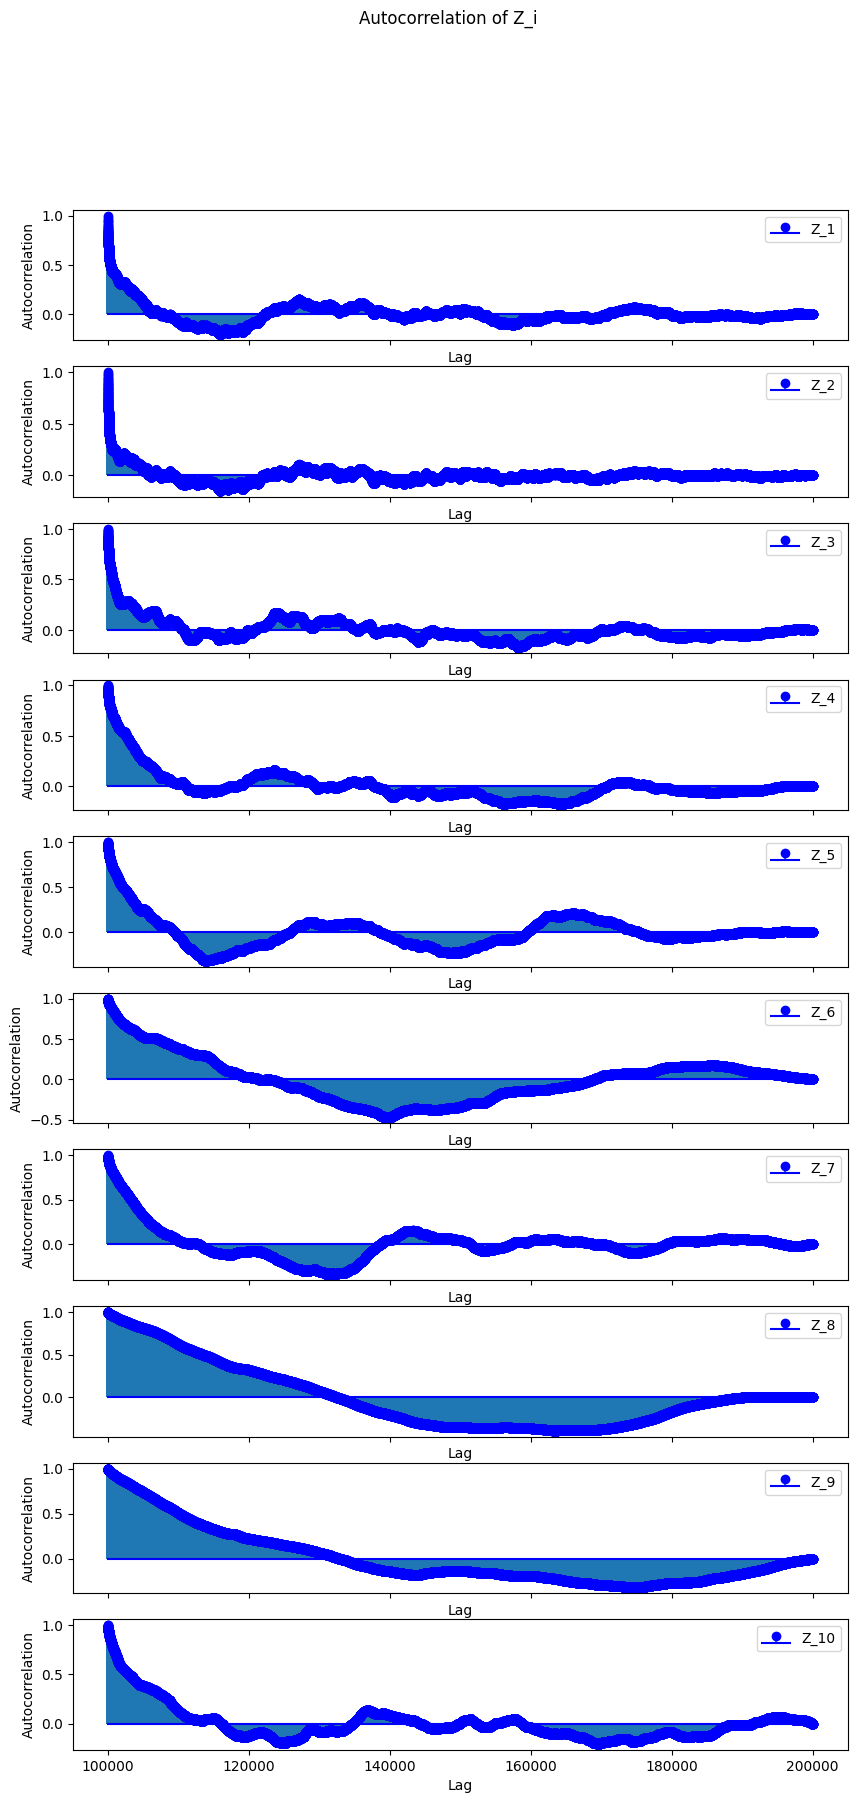

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


KL_trunc_order = 10  # Adjust based on your data
num_iterations = N# Adjust based on your data

# Calculate autocorrelation for each Z
autocorrelations = []

for i in range(KL_trunc_order):
    autocorr = np.correlate(MC_x[i, 100000:] - np.mean(MC_x[i, 100000:]), MC_x[i, 100000:] - np.mean(MC_x[i, 100000:]), mode='full')
    autocorr = autocorr / np.max(autocorr)  # Normalize to have values between -1 and 1
    autocorrelations.append(autocorr[num_iterations - 100000-1:])

# Plot autocorrelation for each Z
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 2 * KL_trunc_order), sharex=True)

for i in range(KL_trunc_order):
    axs[i].stem(range(100000,num_iterations), autocorrelations[i], basefmt='b-', markerfmt='bo', label=f'Z_{i+1}')
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('Autocorrelation')
    axs[i].legend()

# Adding title
fig.suptitle('Autocorrelation of Z_i')
plt.show()

# The posterior of the high Zs havign different values of the variance on the diagonal

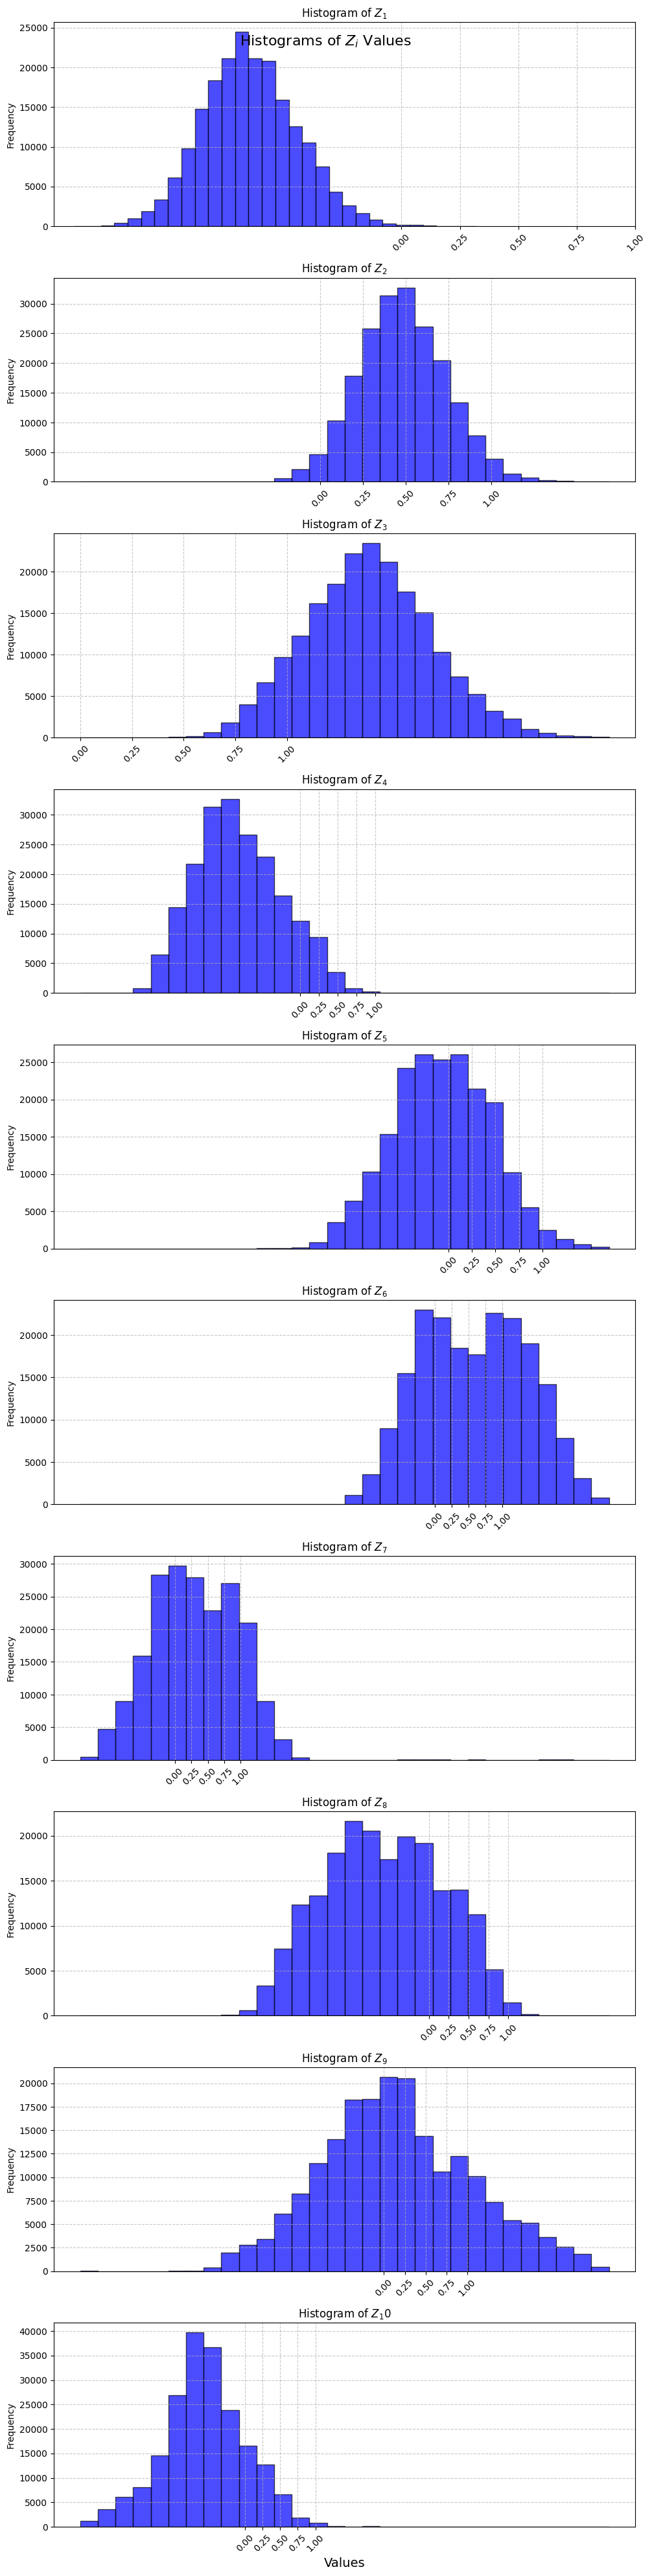

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Assuming x_values is the corresponding array of x-axis values
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N # Adjust based on your data

# Assuming x_values is the corresponding array of x-axis values
x_values = np.linspace(0, 1, num_iterations)  # Adjust based on your data

# Plot histograms for each MC_x[i, :]
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 4 * KL_trunc_order))

for i in range(KL_trunc_order):
    axs[i].hist(MC_x[i, :], bins=30, color='blue', alpha=0.7, edgecolor='black')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram of $Z_{i+1}$')
    axs[i].grid(True, linestyle='--', alpha=0.7)
    axs[i].tick_params(axis='both', labelsize=10)
    axs[i].set_xticks(np.linspace(min(x_values), max(x_values), 5))
    axs[i].set_xticklabels([f'{value:.2f}' for value in np.linspace(min(x_values), max(x_values), 5)])
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility

# Adding labels and title
fig.suptitle('Histograms of $Z_i$ Values', fontsize=16)
axs[-1].set_xlabel('Values', fontsize=14)

plt.tight_layout(pad=0.5, h_pad=1.0, w_pad=0.5)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import invgamma

x =np.arange(0, 1.01, 0.01)

# Get truncated KL modes
mu_y = 1
KL_trunc_order = 10


KL=default_KLE(KL_trunc_order, num_quad = 100)

psi, lambda_ = eval_KLE(KL,x, z = None)


# Create mean and covariance matrices for prior and likelihood
alpha_prior = 2.0
beta_prior= 1e-4
sigma_e_2_prior = invgamma.rvs(a=alpha_prior, scale=beta_prior)
cov_data_obs = np.diag(sigma_e_2_prior * np.ones(10)) # Given in the project, variance of the noise
cov_Z_prior = np.diag(np.ones(KL_trunc_order)) # Identity matrix is the prior since prior we work with the asusmption that the Zs are iid standard normal
mean_Z_prior = np.zeros(KL_trunc_order)

# Parameters for the PDE solver
u_r = 1
F = -1
m_wall = np.array([0.2, 0.4, 0.6, 0.8])
s_width = 0.05
s_strength = 0.8

s = np.zeros_like(x) # How the source term was defined
for i in range(len(x)):
    s[i] = (s_strength / (np.sqrt(2 * np.pi) * s_width)) * np.sum(
        np.exp(-0.5 * ((x[i] - m_wall) ** 2) / s_width ** 2)
    )

N=200001

# MCMC Random walk parameter try for one parameter
np.random.seed(5)
cov_MCMC = 0.5**2*np.eye(10)

MC_x = np.zeros((KL_trunc_order, N))

Y_1 = mu_y + (MC_x[:, 0]).dot(psi.T) # Gaussian prior

k_1 = np.exp(Y_1)

obs_mean_1 = diffusioneqn(x, F, k_1,s,u_r)
obs_mean_prev=obs_mean_1

# Start MCMC chains
accept=0
for chain_time in range(1, N):  # Start from 1 since chain_time - 1 is used

    # Adaptive MC
    sd = 2.4 ** 2 / KL_trunc_order
    adaptive_eps = 1e-4

    if chain_time > 5000: # Covariance matrix of the random coefficients
        cov_MCMC = (
            sd * np.cov(MC_x[:, chain_time-1].T)
            + sd * adaptive_eps * np.eye(KL_trunc_order)
        )


    # Proposal (y/x_n)
    #Mc_x: vector mean of joint distribution of Zis
    # covMCMC: Covariance of Zis
    # calc_gauss: returns multivariatenormalpdf

    proposal = mvnrnd(MC_x[:, chain_time - 1], cov_MCMC)
    Y_proposal = mu_y + ( proposal).dot(psi.T)

    k_proposal = np.exp(Y_proposal)

    obs_mean_proposal = diffusioneqn(x, F, k_proposal, s, u_r)

    # Evaluate all PDFs for alpha term
    alpha=alpha_prior+KL_trunc_order/2
    beta=beta_prior+0.5*(Uobserved-obs_mean_proposal).T.dot(Uobserved-obs_mean_proposal)
    sigma_e= invgamma.rvs(alpha, scale=beta)
    cov_data_obs = np.diag(sigma_e * np.ones(10))
    pi_y =calc_Gauss_mv(Uobserved, obs_mean_proposal, cov_data_obs)+calc_Gauss_mv(proposal, mean_Z_prior, cov_Z_prior)


    pi_xn = calc_Gauss_mv(Uobserved, obs_mean_prev, cov_data_obs)+calc_Gauss_mv(MC_x[:, chain_time - 1], mean_Z_prior, cov_Z_prior)


    q_xn_y = calc_Gauss_mv(MC_x[:, chain_time - 1], proposal, cov_MCMC)
    q_y_xn = calc_Gauss_mv(proposal, MC_x[:, chain_time - 1], cov_MCMC)


    alpha = min(1, np.exp(pi_y + q_xn_y - pi_xn- q_y_xn))

    # Update next sample
    if np.random.rand() < alpha:
        MC_x[:, chain_time] = proposal
        Y_prev = Y_proposal
        obs_mean_prev = obs_mean_proposal
        accept+=1
    else:
        MC_x[:, chain_time] = MC_x[:, chain_time - 1]







In [ ]:
print('acceptance rate',accept/N)

acceptance rate 0.15053424732876336


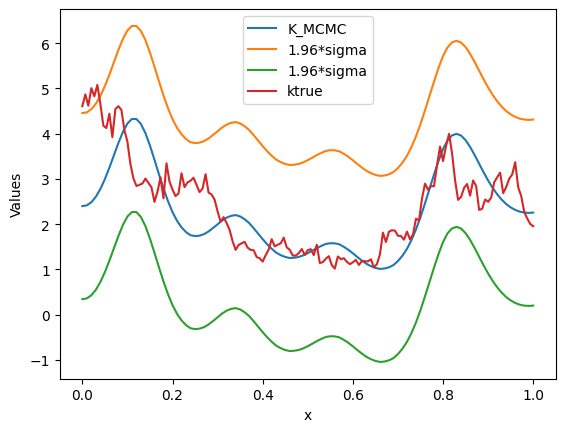

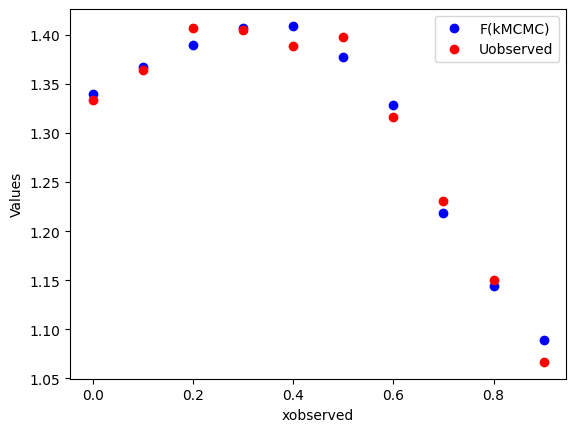

In [ ]:

t_burn_in = 50000
Y_MCMC = np.zeros((len(x), N-t_burn_in))
k_MCMC = np.zeros((len(x), N-t_burn_in))
u_MCMC=np.zeros(N-t_burn_in)
for j in range(t_burn_in , N):
  i = j - t_burn_in
  Y_MCMC[:, i ] = mu_y + (MC_x[:, j ]).dot(psi.T)
  k_MCMC[:, i ] = np.exp(Y_MCMC[:, i ])
  u_MCMC[i]=diffusioneqn(x, F, k_MCMC[:, i ], s, u_r)[0]
import numpy as np
import matplotlib.pyplot as plt

# Assuming x, Y_MCMC, ktrue, xgrid, xobserved, u_r, F, s, mean, std, u_values, and Uobserved are defined



# Plotting the first set of curves
plt.figure()
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]),label='K_MCMC')
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]) + 1.96*np.std(np.exp(Y_MCMC[:,len(Y_MCMC)])), label='1.96*sigma')
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]) - 1.96*np.std(np.exp(Y_MCMC[:,len(Y_MCMC)])), label='1.96*sigma')
# Plotting ktrue
plt.plot(xgrid, k_true, label='ktrue')

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the second set of curves
plt.figure()
plt.plot(xobserved, diffusioneqn(x,F,k_MCMC[:,len(k_MCMC)],s,u_r),'bo', label='F(kMCMC)')
plt.plot(xobserved, Uobserved, 'ro', label='Uobserved')

# Adding labels and legend
plt.xlabel('xobserved')
plt.ylabel('Values')
plt.legend()
plt.show()


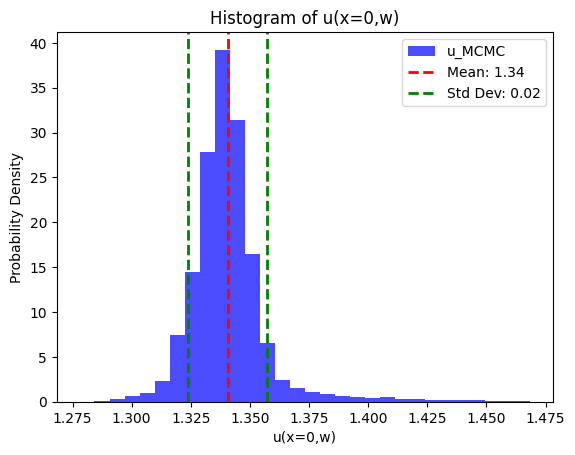

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Plotting the histogram
plt.hist(u_MCMC, bins=30, density=True, alpha=0.7, color='blue', label='u_MCMC')

# Calculate mean and variance
mean_value = np.mean(u_MCMC)
variance_value = np.var(u_MCMC)

# Plotting mean and variance lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mean_value + np.sqrt(variance_value), color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {np.sqrt(variance_value):.2f}')
plt.axvline(mean_value - np.sqrt(variance_value), color='green', linestyle='dashed', linewidth=2)

# Adding labels and title
plt.xlabel('u(x=0,w)')
plt.ylabel('Probability Density')
plt.title('Histogram of u(x=0,w)')
plt.legend()

plt.show()

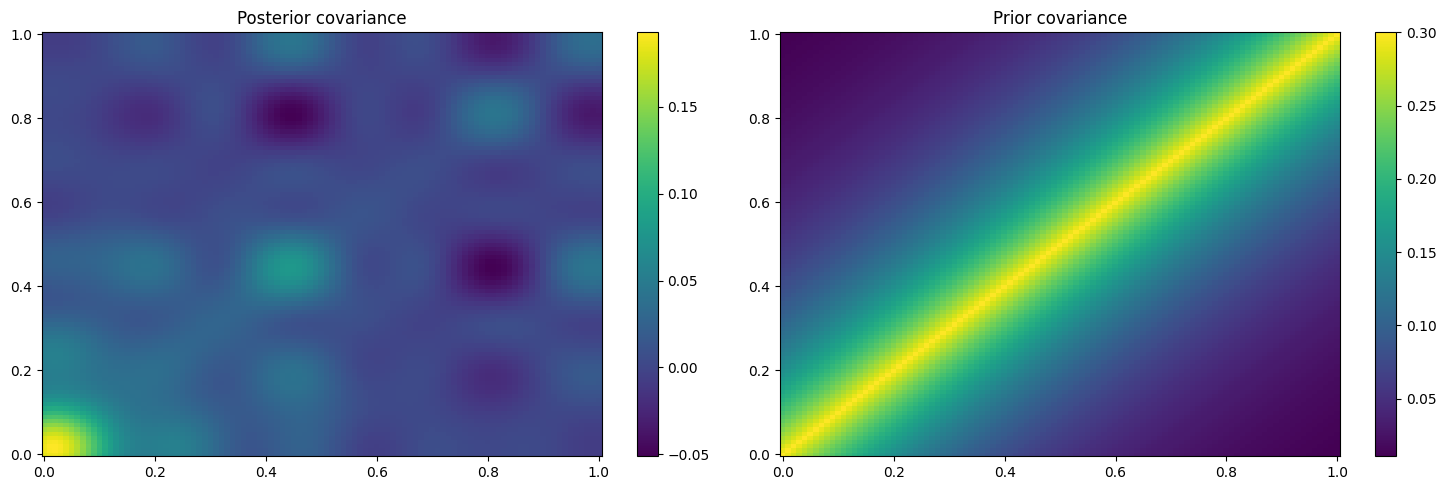

In [ ]:
cov1 = np.cov(Y_MCMC)  # No truncation, no expansion
def covariance(X1,X2):
    Abs = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            Abs[i,j] = np.abs(X1[i]-X2[j])
    return 0.3*np.exp(-(Abs/0.3)**1/1)
cov2=covariance(x,x)




# Create subplots for the three plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first covariance matrix
cax1 = axes[0].pcolor(x, x, cov1)
axes[0].set_title('Posterior covariance')
fig.colorbar(cax1, ax=axes[0])

# Plot the second covariance matrix
cax2 = axes[1].pcolor(x, x, cov2)
axes[1].set_title('Prior covariance')
fig.colorbar(cax2, ax=axes[1])

plt.tight_layout()
plt.show()




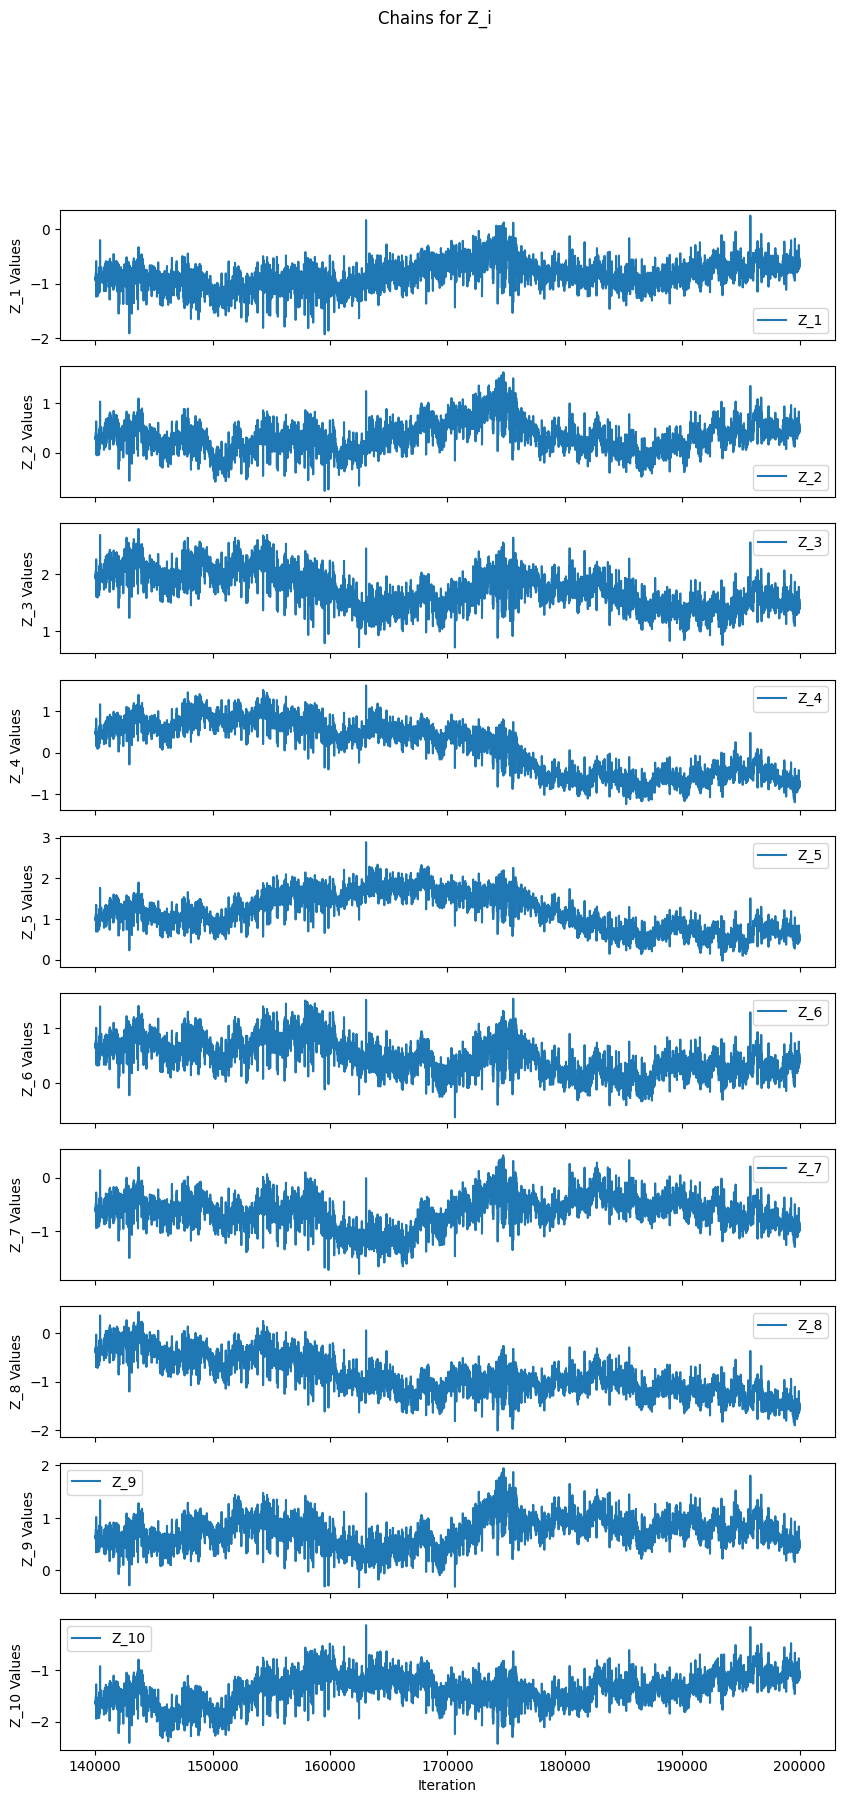

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data
t_burn_in = 140000  # Adjust based on your data

# Plotting all Zi in a single plot with subplots
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 2 * KL_trunc_order), sharex=True)

for i in range(KL_trunc_order):
    axs[i].plot(range(t_burn_in,num_iterations), MC_x[i, t_burn_in:], label=f'Z_{i+1}')
    axs[i].set_ylabel(f'Z_{i+1} Values')
    axs[i].legend()

# Adding labels and title
axs[-1].set_xlabel('Iteration')
fig.suptitle('Chains for Z_i')
plt.show()


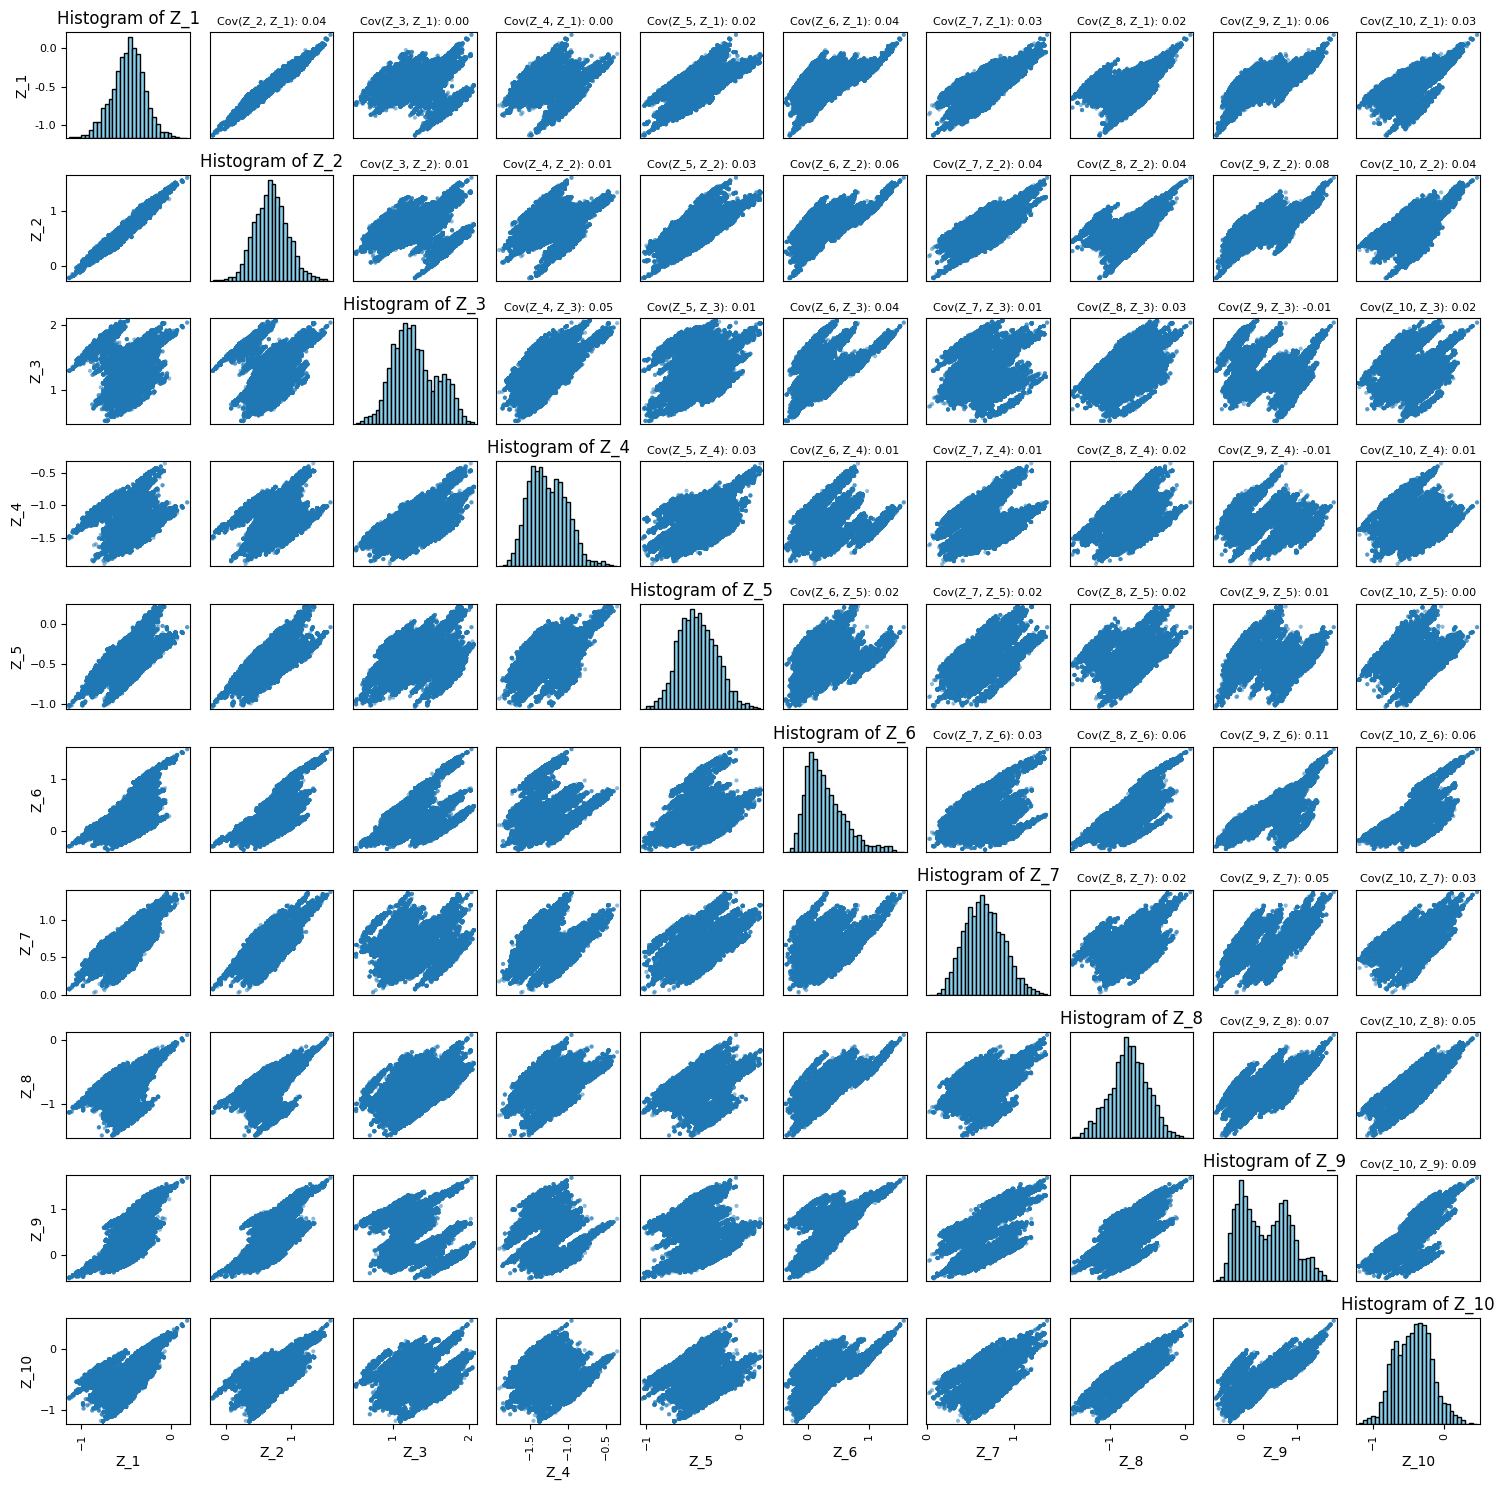

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data
t_burn_in = 140000  # Adjust based on your data

# Create a DataFrame from MC_x
df = pd.DataFrame(MC_x[:, t_burn_in:].T, columns=[f'Z_{i+1}' for i in range(KL_trunc_order)])

# Calculate covariance matrix for MC_x
covariance_matrix = np.cov(df, rowvar=False)

# Create a scatter matrix with histograms
scatter_matrix = pd.plotting.scatter_matrix(df, figsize=(15, 15), diagonal='hist', hist_kwds={'bins': 30, 'color': 'skyblue', 'edgecolor': 'black'})

# Add titles to the diagonal histograms
for i, ax in enumerate(scatter_matrix.diagonal()):
    ax.set_title(f'Histogram of {df.columns[i]}')

# Add covariance values to off-diagonal plots
for i in range(len(scatter_matrix) - 1):
    for j in range(i + 1, len(scatter_matrix)):
        scatter_matrix[i, j].set_title(f'Cov({df.columns[j]}, {df.columns[i]}): {covariance_matrix[i, j]:.2f}', fontsize=8)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


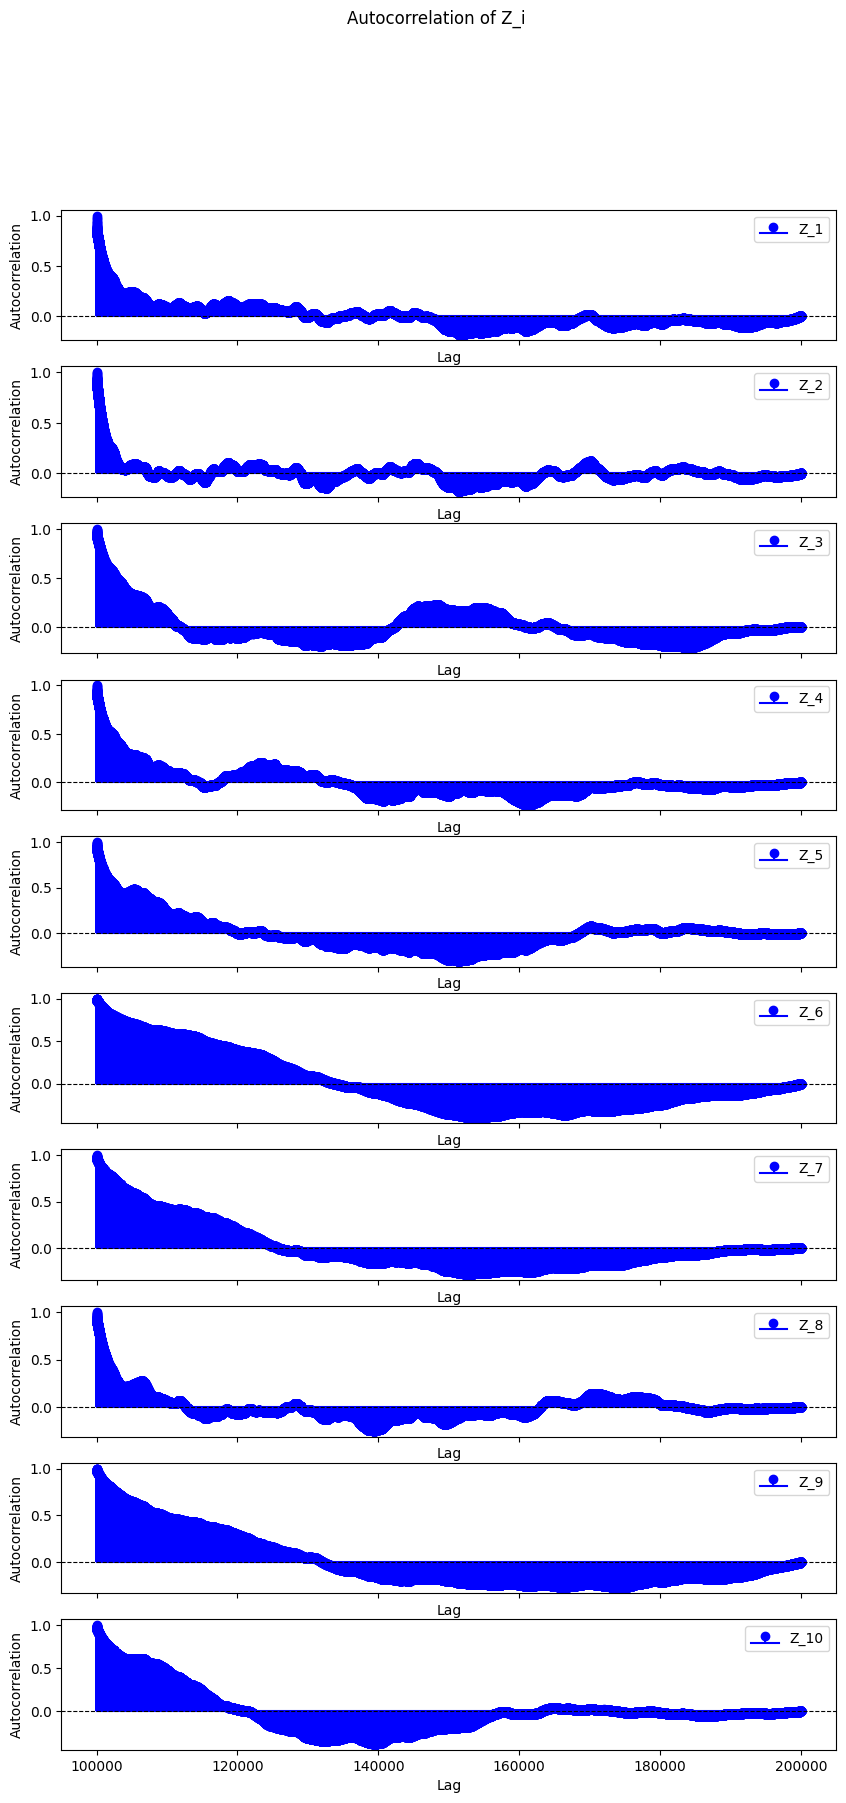

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data
t_burn_in=100000
# Calculate autocorrelation for each Z
autocorrelations = []

for i in range(KL_trunc_order):
    autocorr = np.correlate(
        MC_x[i, t_burn_in:] - np.mean(MC_x[i, t_burn_in:]),
        MC_x[i, t_burn_in:] - np.mean(MC_x[i, t_burn_in:]),
        mode='full'
    )
    autocorr = autocorr / np.max(autocorr)  # Normalize to have values between -1 and 1
    autocorrelations.append(autocorr[num_iterations - t_burn_in - 1:])

# Plot autocorrelation for each Z
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 2 * KL_trunc_order), sharex=True)

for i in range(KL_trunc_order):
    axs[i].stem(
        range(t_burn_in, num_iterations),
        autocorrelations[i],
        basefmt='b-',
        markerfmt='bo',
        linefmt='b-',  # Connect markers with a line
        label=f'Z_{i+1}'
    )
    axs[i].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Add a dashed line at y=0 for clarity
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('Autocorrelation')
    axs[i].legend()

# Adding title
fig.suptitle('Autocorrelation of Z_i')
plt.show()


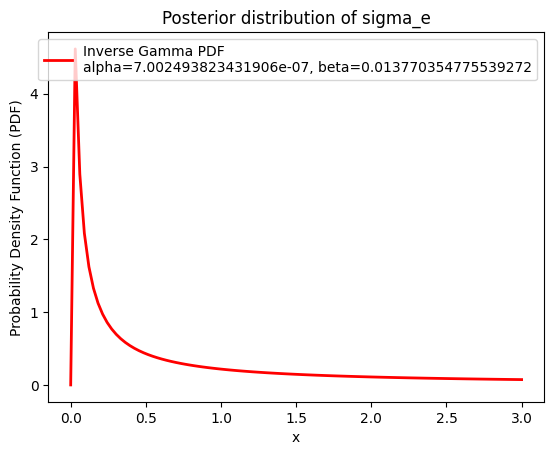

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Generate a range of values for the x-axis using NumPy
x = np.linspace(0.0000000000001, 3, 100)  # Adjust the range as needed

# Calculate the PDF for each value of x using the inverse gamma formula
pdf_values = (beta**alpha / np.math.gamma(alpha)) * x**(-alpha - 1) * np.exp(-beta / x)

# Normalize the PDF to make the area under the curve equal to 1
pdf_values /= np.trapz(pdf_values, x)

# Plot the PDF
plt.plot(x, pdf_values, 'r-', lw=2, label=f'Inverse Gamma PDF\nalpha={alpha}, beta={beta}')
plt.title('Posterior distribution of sigma_e')
plt.xlabel('x')
plt.ylabel('Probability Density Function (PDF)')
plt.legend()
plt.show()



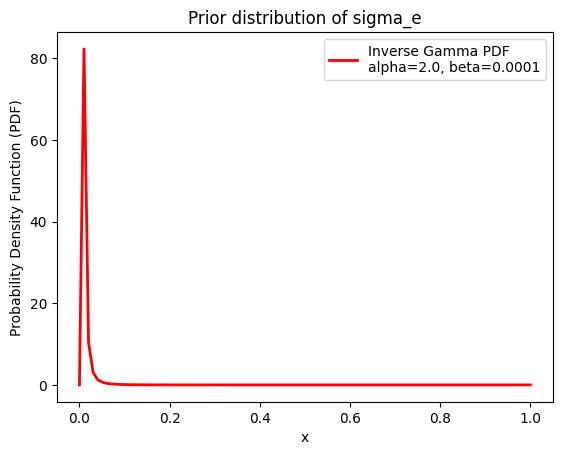

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


beta2=beta_prior
alpha2=alpha_prior
# Generate a range of values for the x-axis using NumPy
x = np.linspace(0.0000000000001, 1, 100)  # Adjust the range as needed

# Calculate the PDF for each value of x using the inverse gamma formula
pdf_values = (beta2**alpha / np.math.gamma(alpha2)) * x**(-alpha2 - 1) * np.exp(-beta2/ x)

# Normalize the PDF to make the area under the curve equal to 1
pdf_values /= np.trapz(pdf_values, x)

# Plot the PDF
plt.plot(x, pdf_values, 'r-', lw=2, label=f'Inverse Gamma PDF\nalpha={alpha2}, beta={beta2}')
plt.title('Prior distribution of sigma_e')
plt.xlabel('x')
plt.ylabel('Probability Density Function (PDF)')
plt.legend()
plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# Parameters
n = 10
M = 5000
np.random.seed(5)

y = Uobserved
Nobs = xobserved.shape[0]
xx = np.arange(0, 1.01, 0.01)  # Adjust the number of points as needed
N = len(xx)
sig_e = 1e-4

# Prior Samples
theta_samples = np.random.multivariate_normal(np.zeros(n), np.eye(n), M).T
k_samples = np.zeros((N, M))
u_samples = np.zeros((len(Uobserved), M))
y_samples = np.zeros((Nobs, M))

# PDE parameters
F = -1.0
ur = 1
s = np.zeros(N)
m = np.array([0.2, 0.4, 0.6, 0.8])
th = 0.8
delta = 0.05
muY = 1.0

for i in range(N):
    for j in range(len(m)):
        s[i] += (th / (delta * np.sqrt(2 * np.pi))) * np.exp(-((xx[i] - m[j]) ** 2) / (2 * delta ** 2))


KL=default_KLE(n, num_quad = 100)

psi, lambda_ = eval_KLE(KL,xx, z = None)
# Compute solutions corresponding to ensemble

for i in range(M):
    Yn=muY +(theta_samples[:,i]).dot(psi.T)
    k_samples[:, i] = np.exp(Yn)
    u_samples[:, i] = diffusioneqn(xx, F, k_samples[:, i], s, ur)+np.random.normal(0,sig_e,Nobs)
    y_samples[:,i]=np.random.multivariate_normal(u_samples[:,i],sig_e*np.eye(Nobs))

sig_Y = np.zeros((Nobs, Nobs))
sig_TY = np.zeros((n, Nobs))
mean_Y = np.mean(y_samples, axis=1)
mean_T = np.mean(theta_samples, axis=1)

for i in range(M):
    sig_Y += np.outer((y_samples[:, i] - mean_Y), (y_samples[:, i] - mean_Y))
    sig_TY += np.outer((theta_samples[:, i] - mean_T), (y_samples[:, i] - mean_Y))



sig_Y /= M
sig_TY /= M
print(np.shape(sig_Y),np.shape(sig_TY))


G = np.dot(sig_TY, np.linalg.inv(sig_Y))

# Update Ensemble
theta_posterior = np.zeros((n, M))
for i in range(M):
    theta_posterior[:, i] = theta_samples[:, i] + np.dot(G, (y - y_samples[:, i]))




(10, 10) (10, 10)


In [18]:
for i in range(M):
  Ynew = muY + (theta_posterior[:, i]).dot(psi.T)
  k_samples[:, i] = np.exp(Ynew)


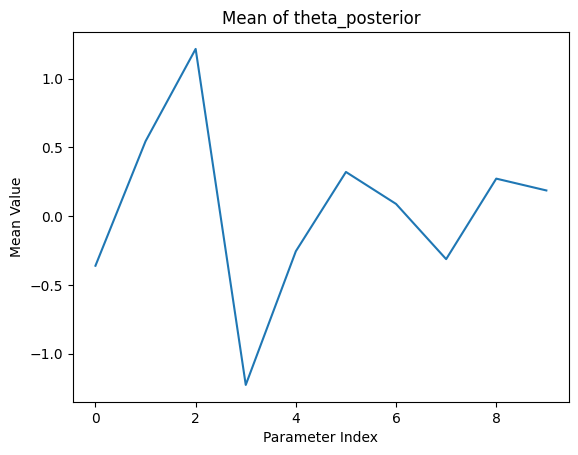

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming theta_posterior is defined in your code

# Calculate the mean of theta_posterior along the columns (axis=1)
mean_theta_posterior = np.mean(theta_posterior, axis=1)

# Plot the mean values
plt.plot(mean_theta_posterior)
plt.title('Mean of theta_posterior')
plt.xlabel('Parameter Index')
plt.ylabel('Mean Value')
plt.show()


In [230]:
np.max(k_samples)

147.60729356847847

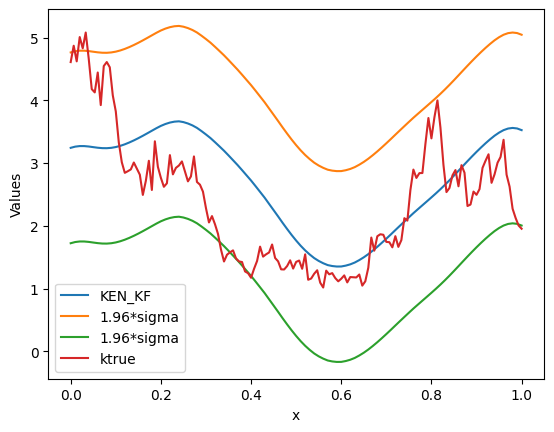

In [20]:




# Plotting the first set of curves
plt.figure()
plt.plot(xx, np.mean(k_samples,axis=1),label='KEN_KF')
plt.plot(xx, np.mean(k_samples,axis=1) + 1.96*np.std(np.mean(k_samples,axis=1)), label='1.96*sigma')
plt.plot(xx, np.mean(k_samples,axis=1) - 1.96*np.std(np.mean(k_samples,axis=1)), label='1.96*sigma')
# Plotting ktrue
plt.plot(xgrid, k_true, label='ktrue')

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()
plt.show()






In [238]:
import numpy as np
import matplotlib.pyplot as plt

# Runge-Kutta Function
def M(Z, dt_obs):
    global beta, rho, sigma, dt
    Nt = round(dt_obs / dt)
    for i in range(Nt):
        X = Z
        k1 = np.array([
            -sigma * X[0] + sigma * X[1],
            -X[0] * X[2] + rho * X[0] - X[1],
            X[0] * X[1] - beta * X[2]
        ])
        X = Z + dt * (k1 / 2)
        k2 = np.array([
            -sigma * X[0] + sigma * X[1],
            -X[0] * X[2] + rho * X[0] - X[1],
            X[0] * X[1] - beta * X[2]
        ])
        X = Z + dt * (k2 / 2)
        k3 = np.array([
            -sigma * X[0] + sigma * X[1],
            -X[0] * X[2] + rho * X[0] - X[1],
            X[0] * X[1] - beta * X[2]
        ])
        X = Z + dt * k3
        k4 = np.array([
            -sigma * X[0] + sigma * X[1],
            -X[0] * X[2] + rho * X[0] - X[1],
            X[0] * X[1] - beta * X[2]
        ])
        Z = Z + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return Z

# Set parameters
beta = 8 / 3
rho = 28
sigma = 10
dt = 0.01

# Generating True Values
Z0 = np.random.randn(3, 1)
Z = Z0
T = 25
dt_obs = 0.05
Nt = round(T / dt_obs)
Z_stored = np.zeros((3, Nt))
sig_sq_dyn = 1e-4

for j in range(Nt):
    Z = M(Z, dt_obs)
    Z_stored[:, j] = Z

Z_stored = np.concatenate([Z_stored], axis=0)

# Synthetic Observations
sig_sq_obs = 4
freq = round(dt_obs / dt)
Zobs_unpert = Z_stored[:, 0:freq:Nt]
Nobs = Zobs_unpert.shape[1]
Y = Zobs_unpert + np.random.multivariate_normal(np.zeros(3), sig_sq_obs * np.eye(3), Nobs).T

# Generating Ensemble at t=0
Nsamp = [int(1e3), int(2e3), int(5e3), int(10e3)]
n = len(Nsamp)
H = np.eye(3)
R = sig_sq_obs * np.eye(3)
time_avg_rmse = np.zeros(n)
mean_post_stored = np.zeros((n, 3, Nobs))
X_stored = [None] * n

# EnKF Algorithm
for k in range(n):
    print(Nsamp[k])
    X = np.random.randn(3, Nsamp[k])
    mean_post = np.zeros((3, Nobs))
    obs_noise = np.random.normal(0, np.sqrt(sig_sq_obs), (3, 1, Nobs, Nsamp[k]))
    dyn_noise = np.random.normal(0, np.sqrt(sig_sq_dyn), (3, 1, Nobs, Nsamp[k]))
    rmse = np.zeros(Nobs)

    for i in range(Nobs):
        # Forecast
        for j in range(Nsamp[k]):
            X[:, j] = M(X[:, j], dt_obs)

        # Sample Covariance
        C = np.cov(X)

        # Kalman Gain
        G = np.dot(np.dot(C, H.T), np.linalg.inv(np.dot(np.dot(H, C), H.T) + R))

        # Update
        for j in range(Nsamp[k]):
            X[:, j] = X[:, j] + np.dot(G, (Y[:, i] - np.dot(H, X[:, j]) + obs_noise[:, :, i, j]))

        mean_post[:, i] = np.mean(X, axis=1)

        # RMSE Calculation
        rmse[i] = np.linalg.norm(mean_post[:, i] - Zobs_unpert[:, i]) / np.sqrt(3)

    X_stored[k] = X
    mean_post_stored[k, :, :] = mean_post

    # Time Averaged RMSE
    time_avg_rmse[k] = np.mean(rmse[round(Nobs / 2):])

# Plotting
# (Your plotting code goes here)


ValueError: ignored